In [178]:
# compare baseline-model, one with just demographics, one with linguistic features, one with acoustic features, one with linguistic + acoustic and a full model with all features

# setup
import sys
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype

# add project root
sys.path.append("/Users/gilanorup/Desktop/Studium/MSc/MA/code/masters_thesis_gn/src")

from config.constants import GIT_DIRECTORY
from regression.regression_helpers import stratified_cross_validation

matplotlib.rcParams["font.family"] = "Arial"

# define task & target
task_name = "cookieTheft"
target = "SemanticFluencyScore"
feature_set = "filtered"

# paths
features_path = os.path.join(GIT_DIRECTORY, f"results/features/filtered/{task_name}_{feature_set}.csv") # switch filtered/cleaned depending on feature-set
scores_path = os.path.join(GIT_DIRECTORY, f"data/language_scores_all_subjects.csv")
demographics_path = os.path.join(GIT_DIRECTORY, f"data/demographics_data.csv")
folds_path = os.path.join(GIT_DIRECTORY, "data", "stratified_folds.csv")
results_path = os.path.join(GIT_DIRECTORY, "results", "regression", "model_comparison", feature_set)

# load data
features = pd.read_csv(features_path)
scores = pd.read_csv(scores_path)
demographics = pd.read_csv(demographics_path)
folds = pd.read_csv(folds_path)

In [179]:
# prepare demographics

# encode Gender: f (female) = 0, m (male) = 1
demographics["Gender"] = demographics["Gender"].map({"f": 0, "m": 1})

# encode Education
education_map = {
    "less_than_highschool": 1,
    "high_school": 2,
    "vocational": 3,
    "bachelor": 4,
    "master": 5,
    "phd": 6,
    "no_answer": np.nan
}
demographics["Education"] = demographics["Education"].map(education_map)

# encode Country: uk = 0, usa = 1
demographics["Country"] = demographics["Country"].map({"uk": 0, "usa": 1})

# drop Language (same information as Country)
demographics.drop(columns=["Language"], inplace=True)

# Socioeconomic is already 1-10


In [180]:
# merge scores and features
df = pd.merge(features, scores[["Subject_ID", target]], on="Subject_ID")
df = pd.merge(df, demographics, on="Subject_ID")
df = pd.merge(df, folds[["Subject_ID", "fold"]], on="Subject_ID")

# define feature sets
# full possible feature lists
linguistic_features = {
    "n_words", "ttr", "mattr_10", "mattr_20", "mattr_30", "mattr_40", "mattr_50", "filler_word_ratio",
    "average_word_length", "brunets_index", "honores_statistic", "guirauds_statistic", "light_verb_ratio",
    "empty_word_ratio", "nid_ratio", "adjacent_repetitions", "aoa_content", "aoa_nouns", "aoa_verbs",
    "fam_content", "fam_nouns", "fam_verbs", "img_content", "img_nouns", "img_verbs", "freq_content",
    "freq_nouns", "freq_verbs", "concr_content", "concr_nouns", "concr_verbs", "um_ratio", "uh_ratio",
    "er_ratio", "ah_ratio", "ADJ", "ADP", "ADV", "AUX", "CCONJ", "DET", "INTJ", "NOUN", "NUM", "PART",
    "PRON", "PROPN", "SCONJ", "VERB", "OTHER", "NOUN/VERB", "PRON/NOUN", "DET/NOUN", "AUX/VERB",
    "OPEN/CLOSED", "INFORMATION_WORDS", "article_pause_contentword"
}
acoustic_features = {
    "phonation_rate", "total_speech_duration", "speech_rate_phonemes", "speech_rate_words", "n_pauses",
    "total_pause_duration", "avg_pause_duration", "short_pause_count", "long_pause_count", "pause_word_ratio",
    "pause_ratio", "pause_rate",
    "eGeMAPS_F0semitoneFrom27.5Hz_sma3nz_amean", "eGeMAPS_F0semitoneFrom27.5Hz_sma3nz_stddevNorm",
    "eGeMAPS_F0semitoneFrom27.5Hz_sma3nz_percentile20.0", "eGeMAPS_F0semitoneFrom27.5Hz_sma3nz_percentile50.0",
    "eGeMAPS_F0semitoneFrom27.5Hz_sma3nz_percentile80.0", "eGeMAPS_F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2",
    "eGeMAPS_F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope", "eGeMAPS_F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope",
    "eGeMAPS_F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope", "eGeMAPS_F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope",
    "eGeMAPS_loudness_sma3_amean", "eGeMAPS_loudness_sma3_stddevNorm", "eGeMAPS_loudness_sma3_percentile20.0",
    "eGeMAPS_loudness_sma3_percentile50.0", "eGeMAPS_loudness_sma3_percentile80.0", "eGeMAPS_loudness_sma3_pctlrange0-2",
    "eGeMAPS_loudness_sma3_meanRisingSlope", "eGeMAPS_loudness_sma3_stddevRisingSlope",
    "eGeMAPS_loudness_sma3_meanFallingSlope", "eGeMAPS_loudness_sma3_stddevFallingSlope",
    "eGeMAPS_spectralFlux_sma3_amean", "eGeMAPS_spectralFlux_sma3_stddevNorm",
    "eGeMAPS_mfcc1_sma3_amean", "eGeMAPS_mfcc1_sma3_stddevNorm", "eGeMAPS_mfcc2_sma3_amean",
    "eGeMAPS_mfcc2_sma3_stddevNorm", "eGeMAPS_mfcc3_sma3_amean", "eGeMAPS_mfcc3_sma3_stddevNorm",
    "eGeMAPS_mfcc4_sma3_amean", "eGeMAPS_mfcc4_sma3_stddevNorm",
    "eGeMAPS_jitterLocal_sma3nz_amean", "eGeMAPS_jitterLocal_sma3nz_stddevNorm",
    "eGeMAPS_shimmerLocaldB_sma3nz_amean", "eGeMAPS_shimmerLocaldB_sma3nz_stddevNorm",
    "eGeMAPS_HNRdBACF_sma3nz_amean", "eGeMAPS_HNRdBACF_sma3nz_stddevNorm",
    "eGeMAPS_logRelF0-H1-H2_sma3nz_amean", "eGeMAPS_logRelF0-H1-H2_sma3nz_stddevNorm",
    "eGeMAPS_logRelF0-H1-A3_sma3nz_amean", "eGeMAPS_logRelF0-H1-A3_sma3nz_stddevNorm",
    "eGeMAPS_F1frequency_sma3nz_amean", "eGeMAPS_F1frequency_sma3nz_stddevNorm",
    "eGeMAPS_F1bandwidth_sma3nz_amean", "eGeMAPS_F1bandwidth_sma3nz_stddevNorm",
    "eGeMAPS_F1amplitudeLogRelF0_sma3nz_amean", "eGeMAPS_F1amplitudeLogRelF0_sma3nz_stddevNorm",
    "eGeMAPS_F2frequency_sma3nz_amean", "eGeMAPS_F2frequency_sma3nz_stddevNorm",
    "eGeMAPS_F2bandwidth_sma3nz_amean", "eGeMAPS_F2bandwidth_sma3nz_stddevNorm",
    "eGeMAPS_F2amplitudeLogRelF0_sma3nz_amean", "eGeMAPS_F2amplitudeLogRelF0_sma3nz_stddevNorm",
    "eGeMAPS_F3frequency_sma3nz_amean", "eGeMAPS_F3frequency_sma3nz_stddevNorm",
    "eGeMAPS_F3bandwidth_sma3nz_amean", "eGeMAPS_F3bandwidth_sma3nz_stddevNorm",
    "eGeMAPS_F3amplitudeLogRelF0_sma3nz_amean", "eGeMAPS_F3amplitudeLogRelF0_sma3nz_stddevNorm",
    "eGeMAPS_alphaRatioV_sma3nz_amean", "eGeMAPS_alphaRatioV_sma3nz_stddevNorm",
    "eGeMAPS_hammarbergIndexV_sma3nz_amean", "eGeMAPS_hammarbergIndexV_sma3nz_stddevNorm",
    "eGeMAPS_slopeV0-500_sma3nz_amean", "eGeMAPS_slopeV0-500_sma3nz_stddevNorm",
    "eGeMAPS_slopeV500-1500_sma3nz_amean", "eGeMAPS_slopeV500-1500_sma3nz_stddevNorm",
    "eGeMAPS_spectralFluxV_sma3nz_amean", "eGeMAPS_spectralFluxV_sma3nz_stddevNorm",
    "eGeMAPS_mfcc1V_sma3nz_amean", "eGeMAPS_mfcc1V_sma3nz_stddevNorm",
    "eGeMAPS_mfcc2V_sma3nz_amean", "eGeMAPS_mfcc2V_sma3nz_stddevNorm",
    "eGeMAPS_mfcc3V_sma3nz_amean", "eGeMAPS_mfcc3V_sma3nz_stddevNorm",
    "eGeMAPS_mfcc4V_sma3nz_amean", "eGeMAPS_mfcc4V_sma3nz_stddevNorm",
    "eGeMAPS_alphaRatioUV_sma3nz_amean", "eGeMAPS_hammarbergIndexUV_sma3nz_amean",
    "eGeMAPS_slopeUV0-500_sma3nz_amean", "eGeMAPS_slopeUV500-1500_sma3nz_amean",
    "eGeMAPS_spectralFluxUV_sma3nz_amean",
    "eGeMAPS_loudnessPeaksPerSec", "eGeMAPS_VoicedSegmentsPerSec", "eGeMAPS_MeanVoicedSegmentLengthSec",
    "eGeMAPS_StddevVoicedSegmentLengthSec", "eGeMAPS_MeanUnvoicedSegmentLength",
    "eGeMAPS_StddevUnvoicedSegmentLength", "eGeMAPS_equivalentSoundLevel_dBp"
}
demographic_cols = ["Age", "Gender", "Education", "Country", "Socioeconomic"]
all_feature_cols = set(df.columns)
linguistic_cols = sorted(list(linguistic_features & all_feature_cols))
acoustic_cols = sorted(list(acoustic_features & all_feature_cols))

model_configs = {
    "baseline": [],
    "demographics": demographic_cols,
    "linguistic": linguistic_cols,
    "acoustic": acoustic_cols,
    "linguistic+acoustic": linguistic_cols + acoustic_cols,
    "full": demographic_cols + linguistic_cols + acoustic_cols
}

In [181]:
# define type of regression
model_type = LinearRegression
# for saving later
model_type_name = model_type.__name__

# loop over model types
results = []
fold_results = []

for model_name, cols in model_configs.items():
    print(f"running model: {model_name} with {len(cols)} features")

    # make sure fold, ID, or target aren't accidentally used as features
    cols = [c for c in cols if c not in ["Subject_ID", "fold", target]]

    # clean X and y for current model (drop missing values)
    X_clean = df[cols].copy() if cols else pd.DataFrame(np.ones((len(df), 1)), columns=["intercept"])
    y_clean = df[target].copy()
    meta = df[["Subject_ID", "fold"]].copy()
    # combine into model_df
    model_df = pd.concat([meta, X_clean, y_clean.rename(target)], axis=1)
    # track and drop NaNs
    before_ids = set(model_df["Subject_ID"])
    model_df = model_df.dropna()
    after_ids = set(model_df["Subject_ID"])
    dropped_ids = before_ids - after_ids
    # print what subjects where dropped
    print(f"{len(dropped_ids)} rows dropped due to NaNs in model '{model_name}':")
    print(sorted(dropped_ids))
    # final clean X and y
    X = model_df[cols] if cols else pd.DataFrame(np.ones((len(df), 1)), columns=["intercept"])
    y = model_df[target]

    # run stratified cross-validation
    r2_list, rmse_list, mae_list, all_preds = stratified_cross_validation(
        df=model_df,
        fold_column="fold",
        model_type=model_type,
        model_params=None, # for random forest: {"n_estimators": 150, "random_state": 42}
        target_column=target,
        feature_columns=X.columns
    )

    # for plot later
    for i, fold in enumerate(all_preds["fold"].unique()):
        fold_results.append({
            "model": model_name,
            "fold": fold,
            "r2": r2_list[i],
            "rmse": rmse_list[i],
            "mae": mae_list[i]
        })

    # calculate statistics
    r2_mean = np.mean(r2_list)
    r2_std = np.std(r2_list)
    r2_se = r2_std / np.sqrt(len(r2_list))
    r2_ci_low = r2_mean - 1.96 * r2_se
    r2_ci_high = r2_mean + 1.96 * r2_se

    # save results
    results.append({
        "model": model_name,
        "r2_mean": r2_mean,
        "r2_std": r2_std,
        "r2_se": r2_se,
        "r2_ci_low": r2_ci_low,
        "r2_ci_high": r2_ci_high,
        "rmse_mean": np.mean(rmse_list),
        "mae_mean": np.mean(mae_list)
    })

# for plot later
df_folds = pd.DataFrame(fold_results)

# save overview
results_df = pd.DataFrame(results)
results_df.to_csv(os.path.join(results_path, f"{task_name}_{target}_model_comparison_{model_type_name}.csv"), index=False)
results_df

running model: baseline with 0 features
13 rows dropped due to NaNs in model 'baseline':
[41, 43, 44, 46, 49, 50, 54, 56, 59, 61, 253, 303, 1079]
running model: demographics with 5 features
13 rows dropped due to NaNs in model 'demographics':
[41, 43, 44, 46, 49, 50, 54, 56, 59, 61, 253, 303, 1079]
running model: linguistic with 42 features
38 rows dropped due to NaNs in model 'linguistic':
[41, 43, 44, 46, 49, 50, 54, 56, 59, 61, 99, 138, 141, 253, 303, 345, 386, 389, 469, 499, 504, 516, 536, 623, 722, 743, 944, 957, 1065, 1079, 1155, 1174, 1176, 1223, 1276, 1350, 1356, 1370]
running model: acoustic with 10 features
19 rows dropped due to NaNs in model 'acoustic':
[41, 43, 44, 46, 49, 50, 54, 56, 59, 61, 138, 149, 253, 303, 469, 516, 772, 1009, 1079]
running model: linguistic+acoustic with 52 features
41 rows dropped due to NaNs in model 'linguistic+acoustic':
[41, 43, 44, 46, 49, 50, 54, 56, 59, 61, 99, 138, 141, 149, 253, 303, 345, 386, 389, 469, 499, 504, 516, 536, 623, 722, 743, 7

,model,r2_mean,r2_std,r2_se,r2_ci_low,r2_ci_high,rmse_mean,mae_mean
0,baseline,-0.010263,0.013160,0.005885,-0.021799,0.001272,2.722410,1.930926
1,demographics,-0.011460,0.041001,0.018336,-0.047398,0.024479,2.721638,1.925541
2,linguistic,0.114571,0.175603,0.078532,-0.039352,0.268494,2.431023,1.763909
3,acoustic,0.094127,0.090668,0.040548,0.014653,0.173601,2.569520,1.862792
4,linguistic+acoustic,0.106731,0.176518,0.078941,-0.047994,0.261456,2.446976,1.784228
5,full,0.106501,0.183487,0.082058,-0.054333,0.267335,2.445809,1.779221


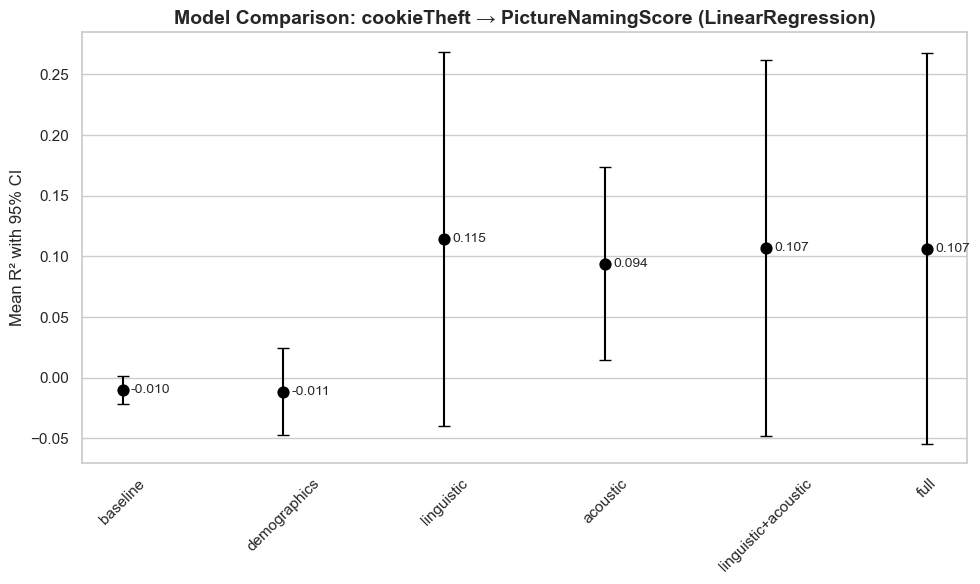

In [182]:
# define custom model order
model_order = ["baseline", "demographics", "linguistic", "acoustic", "linguistic+acoustic", "full"]
cat_type = CategoricalDtype(categories=model_order, ordered=True)
results_df["model"] = results_df["model"].astype(cat_type)

# start plot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.pointplot(
    data=results_df,
    x="model",
    y="r2_mean",
    color="black",
    errorbar=None,
    markers="o",
    linestyles="none"
)

# add CI bars
for i, row in results_df.iterrows():
    plt.errorbar(
        x=i,
        y=row["r2_mean"],
        yerr=[[row["r2_mean"] - row["r2_ci_low"]], [row["r2_ci_high"] - row["r2_mean"]]],
        fmt='none',
        ecolor='black',
        elinewidth=1.5,
        capsize=4
    )

    # add mean R² value above point
    plt.text(
        x=i + 0.05,
        y=row["r2_mean"],
        s=f"{row['r2_mean']:.3f}",
        ha='left',
        va='center',
        fontsize=10
    )

# labels
plt.title(f"Model Comparison: {task_name} → {target} ({model_type_name})", fontsize=14, fontweight="bold")
plt.ylabel("Mean R² with 95% CI")
plt.xlabel("")
plt.xticks(rotation=45)
plt.tight_layout()

# save
plt.savefig(os.path.join(results_path, f"{task_name}_{target}_model_comparison_pointplot_{model_type_name}.png"), dpi=300)
plt.show()

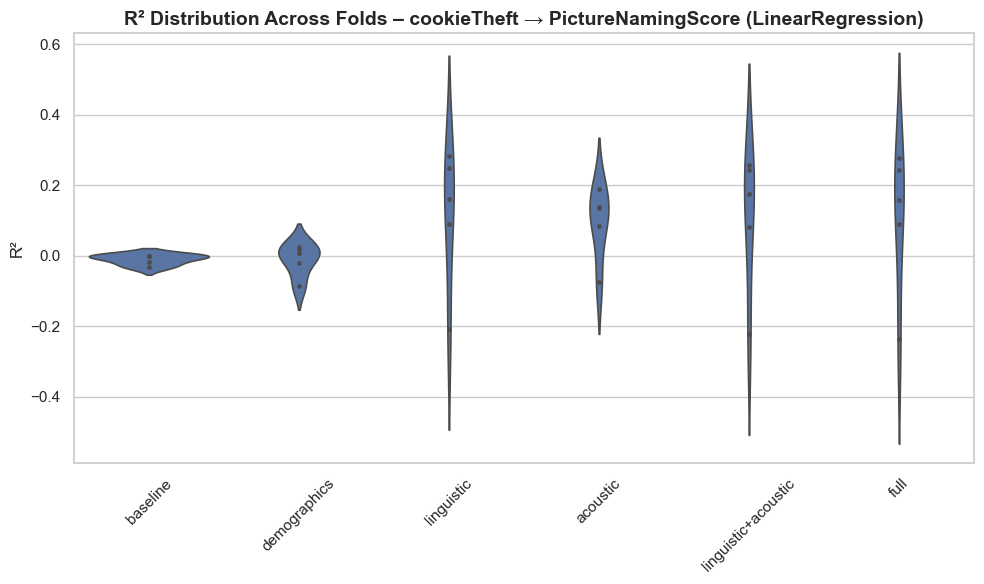

In [183]:
# violin plot for models
df_folds["model"] = df_folds["model"].astype(cat_type)

plt.figure(figsize=(10, 6))
sns.violinplot(data=df_folds, x="model", y="r2", inner="point", linewidth=1.2)
plt.title(f"R² Distribution Across Folds – {task_name} → {target} ({model_type_name})", fontsize=14, fontweight="bold")
plt.ylabel("R²")
plt.xlabel("")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(results_path, f"{task_name}_{target}_r2_violinplot_{model_type_name}.png"), dpi=300)
plt.show()

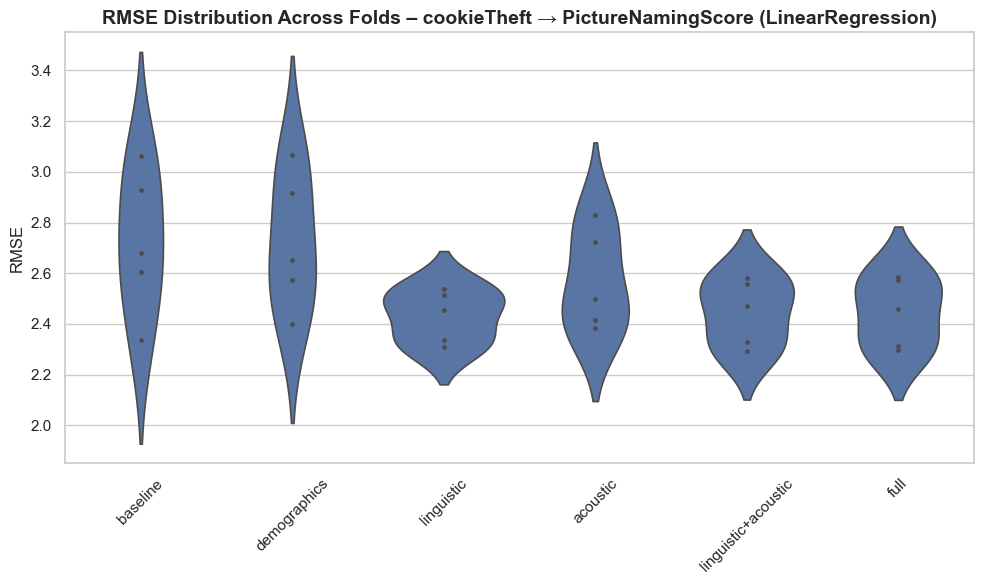

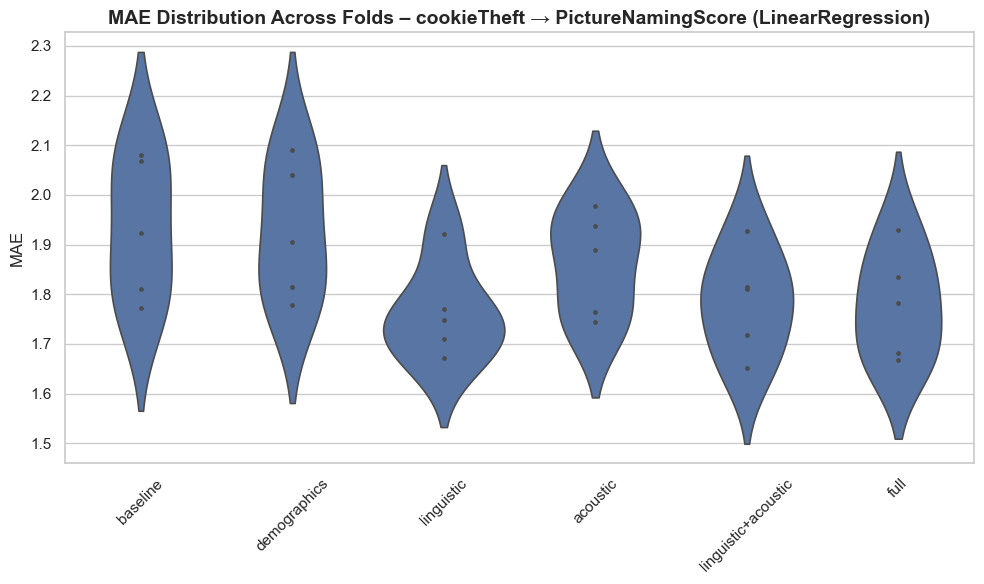

In [184]:
# violin plots with RMSE and MAE

plt.figure(figsize=(10, 6))
sns.violinplot(data=df_folds, x="model", y="rmse", inner="point", linewidth=1.2)
plt.title(f"RMSE Distribution Across Folds – {task_name} → {target} ({model_type_name})", fontsize=14, fontweight="bold")
plt.ylabel("RMSE")
plt.xlabel("")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(results_path, f"{task_name}_{target}_rmse_violinplot_{model_type_name}.png"), dpi=300)
plt.show()

plt.figure(figsize=(10, 6))
sns.violinplot(data=df_folds, x="model", y="mae", inner="point", linewidth=1.2)
plt.title(f"MAE Distribution Across Folds – {task_name} → {target} ({model_type_name})", fontsize=14, fontweight="bold")
plt.ylabel("MAE")
plt.xlabel("")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(results_path, f"{task_name}_{target}_mae_violinplot_{model_type_name}.png"), dpi=300)
plt.show()